In [1]:
from ToxicTextsDataset import ToxicTextsDataset 
from ToxicTextsDatasetBinary import ToxicTextsDatasetBinary 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from skopt import BayesSearchCV

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data as td

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Simple classifiers

In [10]:
df = pd.read_csv('train.csv')
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1], df.iloc[:,2:], test_size=.2)


[Text(0,0,'Positive'), Text(0,0,'Negative')]

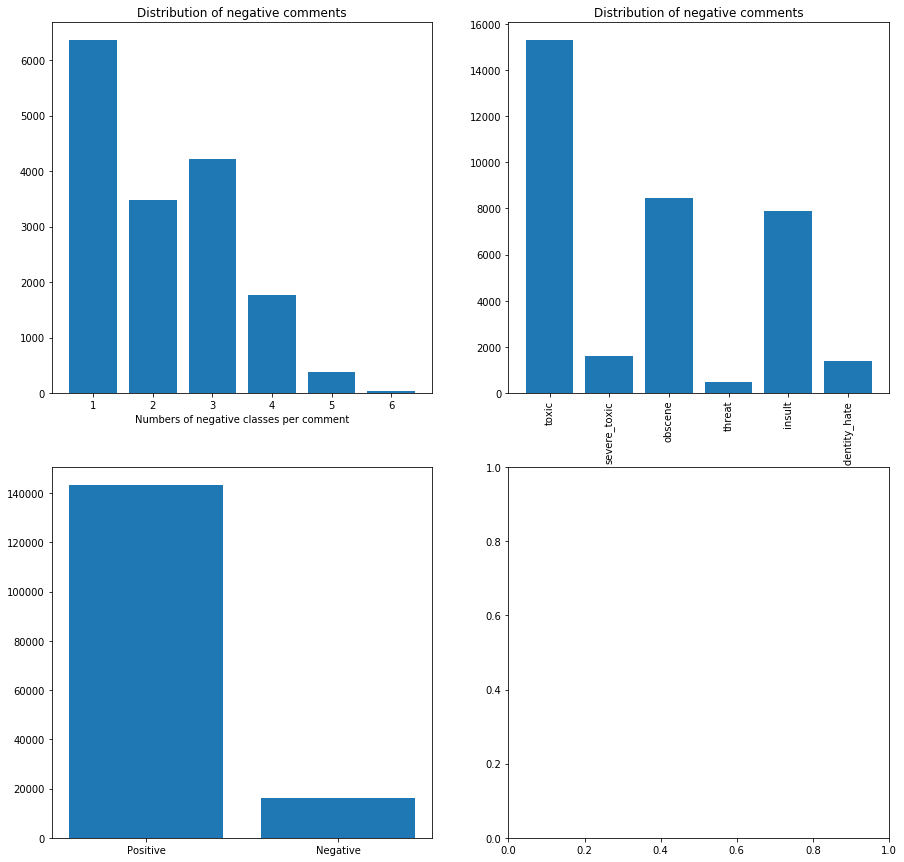

In [5]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15,15))

tot = np.array(np.sum(df.iloc[:,2:], axis = 1))
tot_bad = tot[np.where(tot != 0)]
tot_all = tot > 0

tot_tr = np.sum(df.iloc[:,2:], axis = 0)

#ax[0,0].hist(tot_bad)

ax[0,0].bar(np.arange(1,7), np.unique(tot_bad, return_counts=True)[1])
ax[0,0].set_xticks(np.arange(1,7))

ax[0,0].set_title('Distribution of negative comments')
ax[0,0].set_xlabel('Numbers of negative classes per comment')


ax[0,1].bar(np.arange(6), tot_tr)
ax[0,1].set_xticks(np.arange(6))
ax[0,1].set_xticklabels(tot_tr.index, rotation='vertical')
ax[0,1].set_title('Distribution of negative comments')
ax[1,0].bar(np.array([0,1]), np.array([tot_all.shape[0] - sum(tot_all), sum(tot_all)]))
ax[1,0].set_xticks(np.array([0,1]))
ax[1,0].set_xticklabels(np.array(['Positive', 'Negative']))
#ax[1,0].set_xlabel('Positive/Negative')

In [13]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(df.iloc[:,1])

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(df.iloc[:,1])

train_word_features = word_vectorizer.transform(X_train)
test_word_features = word_vectorizer.transform(X_test)
full_word_features = word_vectorizer.transform(df.iloc[:,1])

train_char_features = char_vectorizer.transform(X_train)
test_char_features = char_vectorizer.transform(X_test)
full_char_features = char_vectorizer.transform(df.iloc[:,1])

X_train = hstack([train_char_features, train_word_features]).tocsr()
X_test = hstack([test_char_features, test_word_features]).tocsr()

#full  training dataset
X = hstack([full_word_features, full_char_features]).tocsr()
y = df.iloc[:,2:]

In [ ]:
### LOG and Huber return proba
opt = BayesSearchCV(
    OneVsRestClassifier(SGDClassifier(tol = 1e-5, n_jobs=-1, max_iter = 20000)),
    {   'estimator__loss': ['log','modified_huber'],
        'estimator__penalty':['l1', 'l2', 'elasticnet'],
        'estimator__alpha': (1e-4, 1e+2, 'log-uniform')
    },
    n_iter=18,
    verbose = 5,
    return_train_score = True,
    scoring = make_scorer(roc_auc_score, needs_proba=True)
)

opt.fit(X_train, y_train)
print("\n")
print("val. score: {}\n".format(opt.best_score_))
print("best params: {}\n".format(opt.best_params_))
print("test score: {}\n".format(opt.score(X_test, y_test)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.000223325697593, estimator__loss=modified_huber, estimator__penalty=l1 
[CV]  estimator__alpha=0.000223325697593, estimator__loss=modified_huber, estimator__penalty=l1, score=0.9213092578546421, total= 1.1min
[CV] estimator__alpha=0.000223325697593, estimator__loss=modified_huber, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  estimator__alpha=0.000223325697593, estimator__loss=modified_huber, estimator__penalty=l1, score=0.9213430724263313, total= 1.2min
[CV] estimator__alpha=0.000223325697593, estimator__loss=modified_huber, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.3min remaining:    0.0s


[CV]  estimator__alpha=0.000223325697593, estimator__loss=modified_huber, estimator__penalty=l1, score=0.917221159928034, total=  54.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.133823435579, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished


[CV]  estimator__alpha=0.133823435579, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=13.7min
[CV] estimator__alpha=0.133823435579, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 13.7min remaining:    0.0s


[CV]  estimator__alpha=0.133823435579, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=13.6min
[CV] estimator__alpha=0.133823435579, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 27.3min remaining:    0.0s


[CV]  estimator__alpha=0.133823435579, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=13.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=18.2647655223, estimator__loss=modified_huber, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 40.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 40.8min finished


[CV]  estimator__alpha=18.2647655223, estimator__loss=modified_huber, estimator__penalty=l2, score=0.7197358328165752, total= 3.8min
[CV] estimator__alpha=18.2647655223, estimator__loss=modified_huber, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


[CV]  estimator__alpha=18.2647655223, estimator__loss=modified_huber, estimator__penalty=l2, score=0.7239508712269896, total= 3.8min
[CV] estimator__alpha=18.2647655223, estimator__loss=modified_huber, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.7min remaining:    0.0s


[CV]  estimator__alpha=18.2647655223, estimator__loss=modified_huber, estimator__penalty=l2, score=0.7262349784720415, total= 4.0min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.000147859192202, estimator__loss=log, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.6min finished


[CV]  estimator__alpha=0.000147859192202, estimator__loss=log, estimator__penalty=l1, score=0.9201017566385934, total= 1.7min
[CV] estimator__alpha=0.000147859192202, estimator__loss=log, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV]  estimator__alpha=0.000147859192202, estimator__loss=log, estimator__penalty=l1, score=0.9244469563421686, total= 1.7min
[CV] estimator__alpha=0.000147859192202, estimator__loss=log, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


[CV]  estimator__alpha=0.000147859192202, estimator__loss=log, estimator__penalty=l1, score=0.9230597668700348, total= 1.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=1.38060567544, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min finished


[CV]  estimator__alpha=1.38060567544, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=64.9min
[CV] estimator__alpha=1.38060567544, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 64.9min remaining:    0.0s


[CV]  estimator__alpha=1.38060567544, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=64.2min
[CV] estimator__alpha=1.38060567544, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 129.1min remaining:    0.0s


[CV]  estimator__alpha=1.38060567544, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=64.7min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.000180008030808, estimator__loss=log, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 193.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 193.8min finished


[CV]  estimator__alpha=0.000180008030808, estimator__loss=log, estimator__penalty=l2, score=0.9550641809211503, total=  19.7s
[CV] estimator__alpha=0.000180008030808, estimator__loss=log, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s


[CV]  estimator__alpha=0.000180008030808, estimator__loss=log, estimator__penalty=l2, score=0.9585289758483878, total=  25.1s
[CV] estimator__alpha=0.000180008030808, estimator__loss=log, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.6s remaining:    0.0s


[CV]  estimator__alpha=0.000180008030808, estimator__loss=log, estimator__penalty=l2, score=0.9579974879287948, total=  20.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.00108488121282, estimator__loss=modified_huber, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


[CV]  estimator__alpha=0.00108488121282, estimator__loss=modified_huber, estimator__penalty=l2, score=0.9826030013301749, total=  10.0s
[CV] estimator__alpha=0.00108488121282, estimator__loss=modified_huber, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV]  estimator__alpha=0.00108488121282, estimator__loss=modified_huber, estimator__penalty=l2, score=0.9835911367795963, total=   9.7s
[CV] estimator__alpha=0.00108488121282, estimator__loss=modified_huber, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s


[CV]  estimator__alpha=0.00108488121282, estimator__loss=modified_huber, estimator__penalty=l2, score=0.983192919209793, total=  11.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=9.22835610717, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.9s finished


[CV]  estimator__alpha=9.22835610717, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=15.6min
[CV] estimator__alpha=9.22835610717, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 15.6min remaining:    0.0s


[CV]  estimator__alpha=9.22835610717, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=15.8min
[CV] estimator__alpha=9.22835610717, estimator__loss=modified_huber, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 31.4min remaining:    0.0s


[CV]  estimator__alpha=9.22835610717, estimator__loss=modified_huber, estimator__penalty=elasticnet, score=0.5, total=15.4min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.000139550605637, estimator__loss=log, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 46.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 46.9min finished


[CV]  estimator__alpha=0.000139550605637, estimator__loss=log, estimator__penalty=elasticnet, score=0.9607758547337268, total=  30.7s
[CV] estimator__alpha=0.000139550605637, estimator__loss=log, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


[CV]  estimator__alpha=0.000139550605637, estimator__loss=log, estimator__penalty=elasticnet, score=0.9616685034496499, total=  30.3s
[CV] estimator__alpha=0.000139550605637, estimator__loss=log, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  estimator__alpha=0.000139550605637, estimator__loss=log, estimator__penalty=elasticnet, score=0.9610532513232104, total=  36.1s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0693255731162, estimator__loss=log, estimator__penalty=l1 
[CV]  estimator__alpha=0.0693255731162, estimator__loss=log, estimator__penalty=l1, score=0.5, total=46.7min
[CV] estimator__alpha=0.0693255731162, estimator__loss=log, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 46.7min remaining:    0.0s


[CV]  estimator__alpha=0.0693255731162, estimator__loss=log, estimator__penalty=l1, score=0.5, total=46.6min
[CV] estimator__alpha=0.0693255731162, estimator__loss=log, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 93.3min remaining:    0.0s


In [7]:
## perceptron and hinge (do not return proba)
opt_2 = BayesSearchCV(
    OneVsRestClassifier(SGDClassifier(tol = 1e-5, n_jobs=-1, max_iter = 20000)),
    {   'estimator__loss': ['hinge', 'perceptron'],
        'estimator__penalty':['l1', 'l2', 'elasticnet'],
        'estimator__alpha': (1e-4, 1e+2, 'log-uniform')
    },
    n_iter=18,
    verbose = 5,
    return_train_score = True,
    scoring = make_scorer(roc_auc_score)
)


opt_2.fit(X_train, y_train)
print("\n")
print("val. score: {}\n".format(opt_2.best_score_))
print("best params: {}\n".format(opt_2.best_params_))
print("test score: {}\n".format(opt_2.score(X_test, y_test)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=6.22813792869, estimator__loss=perceptron, estimator__penalty=l2 
[CV]  estimator__alpha=6.22813792869, estimator__loss=perceptron, estimator__penalty=l2, score=0.5, total=   4.9s
[CV] estimator__alpha=6.22813792869, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV]  estimator__alpha=6.22813792869, estimator__loss=perceptron, estimator__penalty=l2, score=0.5, total=   4.2s
[CV] estimator__alpha=6.22813792869, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.8s remaining:    0.0s


[CV]  estimator__alpha=6.22813792869, estimator__loss=perceptron, estimator__penalty=l2, score=0.5, total=   4.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0170586622307, estimator__loss=hinge, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.8s finished


[CV]  estimator__alpha=0.0170586622307, estimator__loss=hinge, estimator__penalty=l1, score=0.5, total=   7.3s
[CV] estimator__alpha=0.0170586622307, estimator__loss=hinge, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV]  estimator__alpha=0.0170586622307, estimator__loss=hinge, estimator__penalty=l1, score=0.5, total=   7.4s
[CV] estimator__alpha=0.0170586622307, estimator__loss=hinge, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.4s remaining:    0.0s


[CV]  estimator__alpha=0.0170586622307, estimator__loss=hinge, estimator__penalty=l1, score=0.5, total=   7.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0461933579111, estimator__loss=hinge, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s finished


[CV]  estimator__alpha=0.0461933579111, estimator__loss=hinge, estimator__penalty=elasticnet, score=0.5, total=   7.4s
[CV] estimator__alpha=0.0461933579111, estimator__loss=hinge, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  estimator__alpha=0.0461933579111, estimator__loss=hinge, estimator__penalty=elasticnet, score=0.5, total=   7.4s
[CV] estimator__alpha=0.0461933579111, estimator__loss=hinge, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.5s remaining:    0.0s


[CV]  estimator__alpha=0.0461933579111, estimator__loss=hinge, estimator__penalty=elasticnet, score=0.5, total=   7.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.00109722117715, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.8s finished


[CV]  estimator__alpha=0.00109722117715, estimator__loss=perceptron, estimator__penalty=l2, score=0.7592151553375595, total=   6.7s
[CV] estimator__alpha=0.00109722117715, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV]  estimator__alpha=0.00109722117715, estimator__loss=perceptron, estimator__penalty=l2, score=0.7513337369790477, total=   6.5s
[CV] estimator__alpha=0.00109722117715, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.9s remaining:    0.0s


[CV]  estimator__alpha=0.00109722117715, estimator__loss=perceptron, estimator__penalty=l2, score=0.7550658646786341, total=   6.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.30581370182, estimator__loss=hinge, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.3s finished


[CV]  estimator__alpha=0.30581370182, estimator__loss=hinge, estimator__penalty=l2, score=0.5, total=39.3min
[CV] estimator__alpha=0.30581370182, estimator__loss=hinge, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 39.3min remaining:    0.0s


[CV]  estimator__alpha=0.30581370182, estimator__loss=hinge, estimator__penalty=l2, score=0.5, total=38.0min
[CV] estimator__alpha=0.30581370182, estimator__loss=hinge, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 77.3min remaining:    0.0s


[CV]  estimator__alpha=0.30581370182, estimator__loss=hinge, estimator__penalty=l2, score=0.5, total=38.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.00184040613178, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 115.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 115.6min finished


[CV]  estimator__alpha=0.00184040613178, estimator__loss=perceptron, estimator__penalty=l2, score=0.7454435727048506, total=   7.4s
[CV] estimator__alpha=0.00184040613178, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  estimator__alpha=0.00184040613178, estimator__loss=perceptron, estimator__penalty=l2, score=0.7609953713058201, total=   6.1s
[CV] estimator__alpha=0.00184040613178, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV]  estimator__alpha=0.00184040613178, estimator__loss=perceptron, estimator__penalty=l2, score=0.7464154096840954, total=   6.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.000369108957875, estimator__loss=hinge, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s finished


[CV]  estimator__alpha=0.000369108957875, estimator__loss=hinge, estimator__penalty=elasticnet, score=0.6068142869676997, total=  10.2s
[CV] estimator__alpha=0.000369108957875, estimator__loss=hinge, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV]  estimator__alpha=0.000369108957875, estimator__loss=hinge, estimator__penalty=elasticnet, score=0.6073533447453927, total=   9.6s
[CV] estimator__alpha=0.000369108957875, estimator__loss=hinge, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.6s remaining:    0.0s


[CV]  estimator__alpha=0.000369108957875, estimator__loss=hinge, estimator__penalty=elasticnet, score=0.6038645044226644, total=  11.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.00117472140611, estimator__loss=hinge, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.2s finished


[CV]  estimator__alpha=0.00117472140611, estimator__loss=hinge, estimator__penalty=l1, score=0.5622319985855366, total=  18.7s
[CV] estimator__alpha=0.00117472140611, estimator__loss=hinge, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


[CV]  estimator__alpha=0.00117472140611, estimator__loss=hinge, estimator__penalty=l1, score=0.5647797227796904, total=  11.4s
[CV] estimator__alpha=0.00117472140611, estimator__loss=hinge, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.0s remaining:    0.0s


[CV]  estimator__alpha=0.00117472140611, estimator__loss=hinge, estimator__penalty=l1, score=0.5599603022825427, total=  11.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.394418867441, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.9s finished


[CV]  estimator__alpha=0.394418867441, estimator__loss=perceptron, estimator__penalty=l2, score=0.6247956805004395, total=   4.4s
[CV] estimator__alpha=0.394418867441, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  estimator__alpha=0.394418867441, estimator__loss=perceptron, estimator__penalty=l2, score=0.6338098125137467, total=   4.3s
[CV] estimator__alpha=0.394418867441, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.5s remaining:    0.0s


[CV]  estimator__alpha=0.394418867441, estimator__loss=perceptron, estimator__penalty=l2, score=0.6410309311007857, total=   4.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0146657283953, estimator__loss=perceptron, estimator__penalty=l1 
[CV]  estimator__alpha=0.0146657283953, estimator__loss=perceptron, estimator__penalty=l1, score=0.5, total=   7.6s
[CV] estimator__alpha=0.0146657283953, estimator__loss=perceptron, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV]  estimator__alpha=0.0146657283953, estimator__loss=perceptron, estimator__penalty=l1, score=0.5, total=   8.2s
[CV] estimator__alpha=0.0146657283953, estimator__loss=perceptron, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV]  estimator__alpha=0.0146657283953, estimator__loss=perceptron, estimator__penalty=l1, score=0.5, total=   7.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.000135263169058, estimator__loss=perceptron, estimator__penalty=l2 
[CV]  estimator__alpha=0.000135263169058, estimator__loss=perceptron, estimator__penalty=l2, score=0.7655640797908134, total=  10.0s
[CV] estimator__alpha=0.000135263169058, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  estimator__alpha=0.000135263169058, estimator__loss=perceptron, estimator__penalty=l2, score=0.7578376247502865, total=   9.7s
[CV] estimator__alpha=0.000135263169058, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.5s remaining:    0.0s


[CV]  estimator__alpha=0.000135263169058, estimator__loss=perceptron, estimator__penalty=l2, score=0.7580295222283441, total=   9.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2, score=0.6575562044152093, total=  13.8s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2, score=0.6574495396851664, total=  13.0s
[CV] estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.6s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2, score=0.6533783307451941, total=  13.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   43.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=l2 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=l2, score=0.7602533501007742, total=   9.9s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=l2, score=0.7551066979358555, total=  10.0s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=l2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=l2, score=0.7554388125527557, total=  10.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=elasticnet 
[CV]  estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.5, total=   5.9s
[CV] estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.5, total=   5.7s
[CV] estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s


[CV]  estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.5, total=   5.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.7258977584784837, total=  12.2s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.7141392408035108, total=  11.9s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.0s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.717843611061312, total=  11.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=l1 
[CV]  estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=l1, score=0.5, total=   5.7s
[CV] estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=l1, score=0.5, total=   5.7s
[CV] estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s


[CV]  estimator__alpha=100.0, estimator__loss=perceptron, estimator__penalty=l1, score=0.5, total=   5.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s finished
/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.7194327488332387, total=  12.0s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.7216105479986896, total=  12.0s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.7539921752744402, total=  11.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.4s finished
/usr/local/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 
[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.7305552450389216, total=  13.4s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.6747378765836755, total=  12.0s
[CV] estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


[CV]  estimator__alpha=0.0001, estimator__loss=perceptron, estimator__penalty=elasticnet, score=0.6944889916621317, total=  12.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.6s finished




val. score: 0.7604770755898147

best params: {'estimator__alpha': 0.00013526316905775688, 'estimator__loss': 'perceptron', 'estimator__penalty': 'l2'}

test score: 0.7505018934581235



fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
fitting chain 10...
fitting chain 11...
Done!


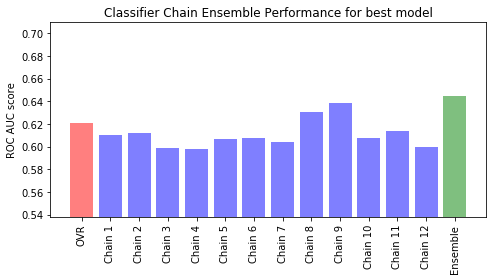

In [8]:


num_chains = 12

loss = 'modified_huber'
alpha = 0.00108488121282
penalty = 'l2'
chain_scores = []


# Independent
clf = SGDClassifier(loss = loss, tol = 1e-5, penalty = penalty, alpha = alpha, n_jobs=-1, max_iter=20000)
ovr = OneVsRestClassifier(clf)
print('fitting ovr...')
ovr.fit(X_train, y_train)
y_pred_ovr = ovr.predict(X_test)
ovr_score = roc_auc_score(y_test, y_pred_ovr)

# Chains
chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]

for k, chain in enumerate(chains):
    print('fitting chain {}...'.format(k))
    chain.fit(X_train, y_train)
print('Done!')

y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_scores = [roc_auc_score(y_test, y_pred_chain)
                     for y_pred_chain in y_pred_chains]

y_pred_ensemble = y_pred_chains.mean(axis=0)
ensemble_score = roc_auc_score(y_test,  y_pred_ensemble)

model_scores = [ovr_score] + chain_scores + [ensemble_score]

model_names = ['OVR'] + ['Chain {}'.format(c+1) for c in range(num_chains)] + ['Ensemble']

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_title('Classifier Chain Ensemble Performance for best model')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('ROC AUC score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
fitting chain 10...
fitting chain 11...
Done!


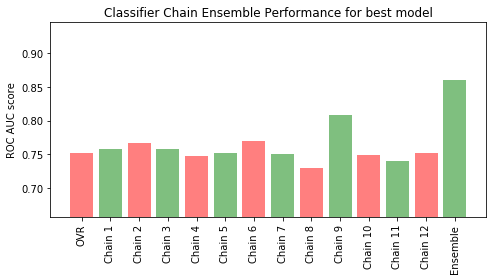

In [9]:
num_chains = 12

loss = opt_2.best_params_['estimator__loss']
alpha = opt_2.best_params_['estimator__alpha']
penalty = opt_2.best_params_['estimator__penalty']
chain_scores = []


# Independent
clf2 = SGDClassifier(loss = loss, tol = 1e-5, penalty = penalty, alpha = alpha, n_jobs=-1, max_iter=20000)
ovr2 = OneVsRestClassifier(clf2)
print('fitting ovr...')
ovr2.fit(X_train, y_train)
y_pred_ovr2 = ovr2.predict(X_test)
ovr_score2 = roc_auc_score(y_test, y_pred_ovr2)

# Chains
chains2 = [ClassifierChain(clf2, order='random', random_state=i) for i in range(num_chains)]

for k, chain in enumerate(chains2):
    print('fitting chain {}...'.format(k))
    chain.fit(X_train, y_train)
print('Done!')

y_pred_chains2 = np.array([chain.predict(X_test) for chain in chains2])
chain_scores2 = [roc_auc_score(y_test, y_pred_chain)
                     for y_pred_chain in y_pred_chains2]

y_pred_ensemble2 = y_pred_chains2.mean(axis=0)
ensemble_score2 = roc_auc_score(y_test,  y_pred_ensemble2)

model_scores2 = [ovr_score2] + chain_scores2 + [ensemble_score2]


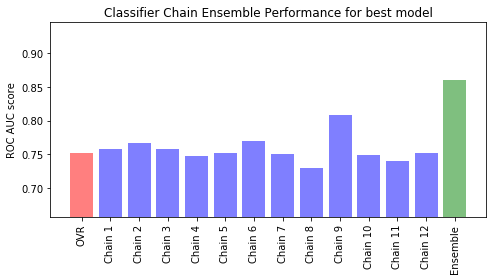

In [14]:
model_names = ['OVR'] + ['Chain {}'.format(c+1) for c in range(num_chains)] + ['Ensemble']

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.set_title('Classifier Chain Ensemble Performance for best model')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('ROC AUC score')
ax.set_ylim([min(model_scores2) * .9, max(model_scores2) * 1.1])
colors = ['r'] + ['b'] * len(chain_scores2) + ['g']
ax.bar(x_pos, model_scores2, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [ ]:
### FIT FULL DATASET
num_chains = 12

loss = opt_2.best_params_['estimator__loss']
alpha = opt_2.best_params_['estimator__alpha']
penalty = opt_2.best_params_['estimator__penalty']
chain_scores = []


clf = SGDClassifier(loss = loss, tol = 1e-6, penalty = penalty, alpha = alpha, n_jobs=-1, max_iter=20000)
# Chains
chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]

for k, chain in enumerate(chains):
    print('fitting chain {}...'.format(k))
    chain.fit(X, y)
print('Done!')

In [ ]:
## Predictions for test dataset

test = pd.read_csv('test.csv')
test_predictions = pd.DataFrame(columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
for ID, line in tqdm.tqdm_notebook(zip(test.iloc[:, 0].astype(str), test.iloc[:, 1]), total=len(test)):
    if(line != '\u2003'):
        test_encoded = hstack([word_vectorizer.transform(line), char_vectorizer.transform(line)])
        pred_chain = np.array([chain.predict(test_encoded) for chain in chains])
        df_new.loc[ID] = pred_chains.mean(axis=0)
    else:
        df_new.loc[ID] = [0., 0., 0., 0., 0., 0.]

df_new.to_csv('test_predictions.csv')